In [1]:
import numpy as np
import pandas as pd

from cmdstanpy import CmdStanModel, set_cmdstan_path
from pathlib import Path

import arviz

import matplotlib.pyplot as plt

set_cmdstan_path("/home/maw501/cmdstan")

In [2]:
def is_incident_smoker(arr):
    arr = arr.values
    if len(arr) == 1 or arr[0] == 1:
        return False
    try:
        first_idx = np.argwhere(arr == 1)[0][0]
        return np.mean(arr[first_idx : len(arr)]) == 1
    except IndexError as ex:
        return False

In [3]:
def calculate_incident_smokers_test_statistic(
    y_pred, df_y_rep, is_incident_smoker
):
    ts = []
    for i in range(y_pred.shape[0]):
        tmp_df = pd.DataFrame(
            {"smkreg": y_pred[i], "newid": df_y_rep["newid"]}
        )
        ts.append(
            np.mean(tmp_df.groupby("newid")["smkreg"].agg(is_incident_smoker))
        )
    return ts

In [4]:
def plot_ppc_hist(ax, test_statistic, test_statistic_y, quantiles, p_value, vline_height, bins=25):
    ax.hist(test_statistic, bins=bins, color="#fa7268")
    ax.vlines(
        quantiles[0], 0, vline_height, linestyle="--", color="grey"
    )
    ax.vlines(
        quantiles[1], 0, vline_height, linestyle="--", color="grey"
    )
    ax.vlines(
        test_statistic_y,
        0,
        vline_height,
        linestyle="--",
        label="$T(y)$",
    )
    ax.set_title(
        f"p-value: {p_value:.3f} \n Test statistic y_rep 95% int: [{quantiles[0]*100:.1f}, {quantiles[1]*100:.1f}] \n Test statistic y: {test_statistic_y*100:.1f}"
    )

### Load data

In [5]:
smoking_data = pd.read_table("../utilities_and_data/smoking/smoke_pub.dat")
num_people = smoking_data["newid"].nunique()
smoking_data["mean_waves_smoked"] = smoking_data.groupby("newid")[
    "smkreg"
].transform("mean")

never_smokers_test_statistic_y = (
    smoking_data.groupby("newid")["smkreg"].agg("mean") == 0
).mean()
always_smokers_test_statistic_y = (
    smoking_data.groupby("newid")["smkreg"].agg("mean") == 1
).mean()

incident_smokers_test_statistic_y = np.mean(
    smoking_data.groupby("newid")["smkreg"].agg(is_incident_smoker)
)

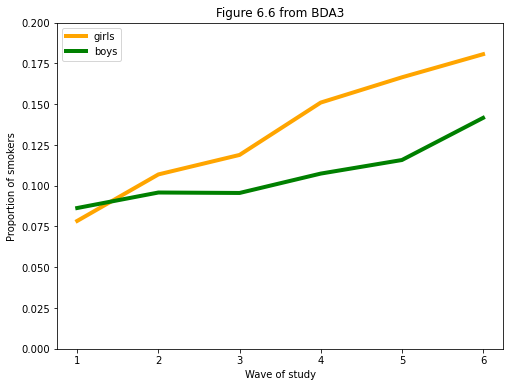

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    smoking_data.loc[smoking_data["sex(1=F)"] == 1]
    .groupby("wave")["smkreg"]
    .mean(),
    label="girls",
    color="orange",
    linewidth=4
)
ax.plot(
    smoking_data.loc[smoking_data["sex(1=F)"] == 0]
    .groupby("wave")["smkreg"]
    .mean(),
    label="boys",
    color="green",
    linewidth=4
)
ax.set_ylim(0, 0.2);
ax.set_xlabel("Wave of study");
ax.set_ylabel("Proportion of smokers")
ax.legend();
ax.set_title("Figure 6.6 from BDA3");

### Data

In [7]:
stan_data = {
    "N_people": num_people,
    "N": len(smoking_data),
    "parent_smoke": smoking_data["parsmk"].values.astype(int),
    "female": smoking_data["sex(1=F)"].values.astype(int),
    "t": smoking_data["wave"].values.astype(int),
    "smoke": smoking_data["smkreg"].values.astype(int),
    "p_idx": smoking_data["newid"].values.astype(int),
}

### Fit model

In [8]:
model = CmdStanModel(stan_file="stan_models/smoking.stan")

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/maw501/ML/maw501_github/BDA_py_demos/demos_ch6/stan_models/smoking


In [9]:
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

In [ ]:
fit = model.sample(
    data=stan_data,
    output_dir=output_dir,
    iter_warmup=1_000,
    iter_sampling=1_000,
    show_progress="notebook",
)

In [ ]:
params = fit.stan_variables()
var_names = ["b0", "b1", "b2", "b3", "b4", "sigma_alpha"]

In [ ]:
inference_data = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(inference_data, var_names=var_names)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

In [ ]:
arviz.plot_trace(fit, var_names=var_names);

### Posterior predictive checking

In [ ]:
df_y_rep = pd.DataFrame(params["y_pred"]).T
df_y_rep["newid"] = smoking_data["newid"].values
df_y_rep_mean_per_person = df_y_rep.groupby("newid").mean().values

In [ ]:
qs = [0.025, 0.975]

never_smokers_test_statistic = (df_y_rep_mean_per_person == 0).mean(0)
never_smokers_quantiles = np.quantile(never_smokers_test_statistic, q=qs)

always_smokers_test_statistic = (df_y_rep_mean_per_person == 1).mean(0)
always_smokers_quantiles = np.quantile(always_smokers_test_statistic, q=qs)

incident_smokers_test_statistic = calculate_incident_smokers_test_statistic(
    params["y_pred"].values, df_y_rep, is_incident_smoker
)
incident_smokers_quantiles = np.quantile(incident_smokers_test_statistic, q=qs)

In [ ]:
never_smokers_p_value = np.mean(
    never_smokers_test_statistic > never_smokers_test_statistic_y
)
always_smokers_p_value = np.mean(
    always_smokers_test_statistic > always_smokers_test_statistic_y
)
incident_smokers_p_value = np.mean(
    incident_smokers_test_statistic > incident_smokers_test_statistic_y
)

In [ ]:
bins = 25
vline_height = 300

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

plot_ppc_hist(ax[0], 
              never_smokers_test_statistic, 
              never_smokers_test_statistic_y, 
              never_smokers_quantiles, 
              never_smokers_p_value, 
              vline_height)
plot_ppc_hist(ax[1], 
              never_smokers_test_statistic, 
              always_smokers_test_statistic_y, 
              always_smokers_quantiles, 
              always_smokers_p_value, 
              vline_height)
plot_ppc_hist(ax[2], 
              incident_smokers_test_statistic, 
              incident_smokers_test_statistic_y, 
              incident_smokers_quantiles, 
              incident_smokers_p_value, 
              vline_height)

plt.suptitle("BDA3 Table 6.1 - Model 1", y=1.05, fontsize=16);

### Fit mixture model

Repeat the above analysis for a mixture model now.

In [ ]:
model_mix = CmdStanModel(stan_file="stan_models/smoking_mixture.stan")

In [ ]:
fit_mix = model_mix.sample(
    data=stan_data,
    output_dir=output_dir,
    iter_warmup=1_000,
    iter_sampling=2_000,
    show_progress="notebook",
)

In [ ]:
params_mix = fit_mix.stan_variables()

In [ ]:
var_names_mix = ["b0", "b1", "b2", "b3", "b4", "gamma_0", "gamma_1", "gamma_2", "sigma_alpha"]

In [ ]:
inference_data_mix = arviz.convert_to_inference_data(fit_mix)
summary_df_mix = (
    arviz.summary(inference_data_mix, var_names=var_names_mix)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

In [ ]:
summary_df_mix.head(10)

In [ ]:
arviz.plot_trace(fit_mix, var_names=var_names_mix);

In [ ]:
df_y_rep_mix = pd.DataFrame(params_mix["y_pred"]).T
df_y_rep_mix["newid"] = smoking_data["newid"].values
df_y_rep_mean_per_person_mix = df_y_rep_mix.groupby("newid").mean().values

In [ ]:
never_smokers_test_statistic_mix = (df_y_rep_mean_per_person_mix == 0).mean(0)
never_smokers_quantiles_mix = np.quantile(never_smokers_test_statistic_mix, q=qs)

always_smokers_test_statistic_mix = (df_y_rep_mean_per_person_mix == 1).mean(0)
always_smokers_quantiles_mix = np.quantile(always_smokers_test_statistic_mix, q=qs)

incident_smokers_test_statistic_mix = calculate_incident_smokers_test_statistic(
    params_mix["y_pred"].values, df_y_rep_mix, is_incident_smoker
)
incident_smokers_quantiles_mix = np.quantile(incident_smokers_test_statistic_mix, q=qs)

In [ ]:
never_smokers_p_value_mix = np.mean(
    never_smokers_test_statistic_mix > never_smokers_test_statistic_y
)
always_smokers_p_value_mix = np.mean(
    always_smokers_test_statistic_mix > always_smokers_test_statistic_y
)
incident_smokers_p_value_mix = np.mean(
    incident_smokers_test_statistic_mix > incident_smokers_test_statistic_y
)

In [ ]:
bins = 25
vline_height = 750

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

plot_ppc_hist(ax[0], 
              never_smokers_test_statistic_mix, 
              never_smokers_test_statistic_y, 
              never_smokers_quantiles_mix, 
              never_smokers_p_value_mix, 
              vline_height)
plot_ppc_hist(ax[1], 
              always_smokers_test_statistic_mix, 
              always_smokers_test_statistic_y, 
              always_smokers_quantiles_mix, 
              always_smokers_p_value_mix, 
              vline_height)
plot_ppc_hist(ax[2], 
              incident_smokers_test_statistic_mix, 
              incident_smokers_test_statistic_y, 
              incident_smokers_quantiles_mix, 
              incident_smokers_p_value_mix, 
              vline_height)

plt.suptitle("BDA3 Table 6.1 - Model 2", y=1.05, fontsize=16);